In [1]:
import numpy as np 
from scipy.integrate import odeint
import os, sys, warnings
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate_nn as srnn
import matplotlib.pyplot as plt
import pandas as pd
import torch
import sample as sm
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
warnings.filterwarnings('ignore')

In [2]:
DTYPE = 'float64'
L63_data_path = '../data/L63-trajectories'
save_folder='../data/rf-start-aggresive'
log_interval = 100
milestones = [10*2**n for n in range(15)]
learning_rate = 1e-3
drop = 0.7
steps = int(1e4)
save_interval = 100
N = 20000
L0 = 0.4
L1 = 3.5
beta = 4e-5

train = np.load(f'{L63_data_path}/train.npy').astype(DTYPE)
test = np.load(f'{L63_data_path}/test.npy')[:, :, :1000].astype(DTYPE)

model = srnn.SurrogateModel_NN(3, 300, name='nn', save_folder=save_folder)
model.init_with_rf(L0, L1, beta, train, partition=[300, 0, 0])
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
tau_f_1 = tau_f_se.mean()
model.learn(train[:, :N], 5000, 1e-4, drop=1., batch_size='GD', log_interval=10, save_interval=10)
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
tau_f_2 = tau_f_se.mean()

tau_f_1 , tau_f_2, tau_f_1 < tau_f_2
model.count_row_types(L0, L1, train.T)

TypeError: SurrogateModel_NN.compute_tau_f() missing 2 required positional arguments: 'train' and 'test'

KeyError: 'good_rows_W_in'

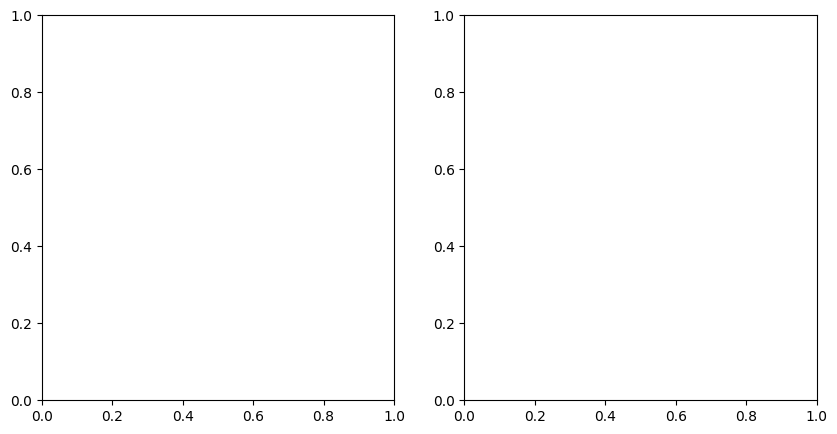

In [3]:
df = pd.read_csv(f'{model.save_folder}/train_log.csv')
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(df['iteration'], df['good_rows_W_in'], c='green', label='good rows')
ax1.plot(df['iteration'], df['linear_rows_W_in'], c='blue', label = 'linear rows')
ax1.plot(df['iteration'], df['extreme_rows_W_in'], c='red', label = 'extreme rows')
ax2.scatter(df['iteration'], np.log(df['loss']), s=1)
ax1.set_xlabel('iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('log loss')
ax1.legend()
plt.savefig(f'{model.save_folder}/row_types.png')

In [ ]:
tau_f_1, tau_f_2

In [4]:
model = srnn.SurrogateModel_NN(3, 300, name='nn', save_folder=save_folder+'-suboptimal-8')
model.init_with_rf(L0, L1, beta, train, partition=[300, 0, 0])
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
tau_f_1 = tau_f_se.mean()
model.learn(train[:, :N], 5000, 1e-5, batch_size='GD', log_interval=100, save_interval=100, last_folder=None,\
           max_delta=0.1, min_change=1e-4, constant_rate=True, update_frequency=1000, mode='BS')
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
tau_f_2 = tau_f_se.mean()

tau_f_1 , tau_f_2, tau_f_1 < tau_f_2
model.count_row_types(L0, L1, train.T)

Time taken by compute_tau_f is 1.4385 seconds
step: 0 loss: 2.032387 time: 0.0438 lr: 0.000010,  change: nan%
step: 100 loss: 2.033980 time: 3.2361 lr: 0.000010,  change: 0.08%
step: 200 loss: 2.032681 time: 6.5094 lr: 0.000010,  change: -0.06%
step: 300 loss: 2.032461 time: 9.6915 lr: 0.000010,  change: -0.01%
step: 400 loss: 2.032369 time: 12.8923 lr: 0.000010,  change: -0.00%
step: 500 loss: 2.032324 time: 16.1828 lr: 0.000010,  change: -0.00%
step: 600 loss: 2.032296 time: 19.3903 lr: 0.000010,  change: -0.00%
step: 700 loss: 2.032276 time: 22.6119 lr: 0.000010,  change: -0.00%
step: 800 loss: 2.032259 time: 25.8564 lr: 0.000010,  change: -0.00%
step: 900 loss: 2.154530 time: 29.0582 lr: 0.000010,  change: 6.02%
step: 1000 loss: 2.032240 time: 32.6327 lr: 0.000010,  change: -5.68%
step: 1100 loss: 2.032226 time: 35.8160 lr: 0.000010,  change: -0.00%
step: 1200 loss: 2.032217 time: 38.9865 lr: 0.000010,  change: -0.00%
step: 1300 loss: 2.051780 time: 42.1712 lr: 0.000010,  change: 0

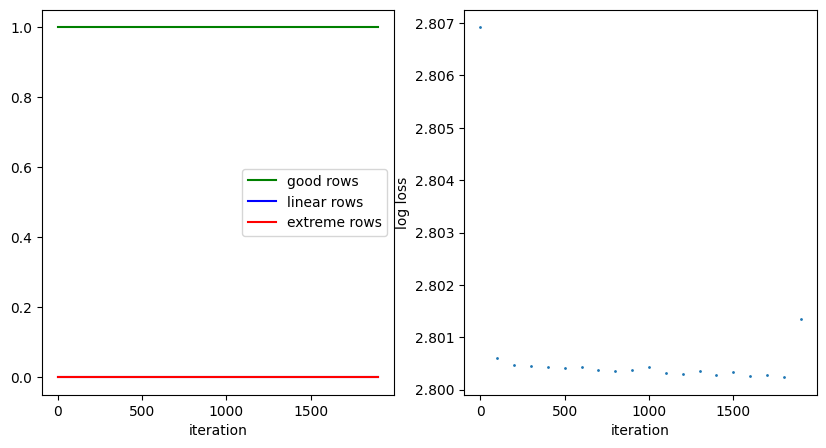

In [8]:
df = pd.read_csv(f'{model.save_folder}/train_log.csv')
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(df['iteration'], df['good_rows_W_in'], c='green', label='good rows')
ax1.plot(df['iteration'], df['linear_rows_W_in'], c='blue', label = 'linear rows')
ax1.plot(df['iteration'], df['extreme_rows_W_in'], c='red', label = 'extreme rows')
ax2.scatter(df['iteration'], (df['loss']), s=1)
ax1.set_xlabel('iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('log loss')
ax1.legend()
plt.show()
# plt.savefig(f'{model.save_folder}/row_types.png')

In [19]:
tau_f_1, tau_f_2

(5.651828, 5.866042000000001)

In [ ]:
save_folder='../data/rf-start-super-aggresive'
model = srnn.SurrogateModel_NN(3, 300, name='nn', save_folder=save_folder+'-suboptimal')
model.init_with_rf(L0, L1, beta, train, partition=[100, 100, 100])
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
tau_f_1 = tau_f_se.mean()
model.learn(train[:, :N], 5000, 1e-3, drop=1., batch_size='GD', log_interval=10, save_interval=10)
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
tau_f_2 = tau_f_se.mean()

tau_f_1 , tau_f_2, tau_f_1 < tau_f_2
model.count_row_types(L0, L1, train.T)

In [ ]:
df = pd.read_csv(f'{model.save_folder}/train_log.csv')
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(df['iteration'], df['good_rows_W_in'], c='green', label='good rows')
ax1.plot(df['iteration'], df['linear_rows_W_in'], c='blue', label = 'linear rows')
ax1.plot(df['iteration'], df['extreme_rows_W_in'], c='red', label = 'extreme rows')
ax2.scatter(df['iteration'], np.log(df['loss']), s=1)
ax1.set_xlabel('iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('log loss')
ax1.legend()
plt.savefig(f'{model.save_folder}/row_types.png')

In [ ]:
tau_f_1,  tau_f_2

In [ ]:
save_folder='../data/rf-start-super-aggresive'
model = srnn.SurrogateModel_NN(3, 300, name='nn', save_folder=save_folder)
model.init_with_rf(L0, L1, beta, train, partition=[300, 0, 0])
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
tau_f_1 = tau_f_se.mean()
model.learn(train[:, :N], 5000, 1e-3, drop=1., batch_size='GD', log_interval=10, save_interval=10)
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
tau_f_2 = tau_f_se.mean()

tau_f_1 , tau_f_2, tau_f_1 < tau_f_2
model.count_row_types(L0, L1, train.T)

In [ ]:
df = pd.read_csv(f'{model.save_folder}/train_log.csv')
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(df['iteration'], df['good_rows_W_in'], c='green', label='good rows')
ax1.plot(df['iteration'], df['linear_rows_W_in'], c='blue', label = 'linear rows')
ax1.plot(df['iteration'], df['extreme_rows_W_in'], c='red', label = 'extreme rows')
ax2.scatter(df['iteration'], np.log(df['loss']), s=1)
ax1.set_xlabel('iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('log loss')
ax1.legend()
plt.savefig(f'{model.save_folder}/row_types.png')

In [ ]:
tau_f_1, tau_f_2

In [ ]:
save_folder='../data/rf-start-none'
model = srnn.SurrogateModel_NN(3, 300, name='nn', save_folder=save_folder)
# model.init_with_rf(L0, L1, beta, train, partition)
model.init_with_rf(L0, L1, beta, train, partition=[300, 0, 0])
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
tau_f_1 = tau_f_se.mean()
model.learn(train[:, :N], 20000, 1e-3, drop=1., batch_size='GD', log_interval=10, save_interval=10)
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
tau_f_2 = tau_f_se.mean()

tau_f_1 , tau_f_2, tau_f_1 < tau_f_2
model.count_row_types(L0, L1, train.T)

In [ ]:
df = pd.read_csv(f'{model.save_folder}/train_log.csv')
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(df['iteration'], df['good_rows_W_in'], c='green', label='good rows')
ax1.plot(df['iteration'], df['linear_rows_W_in'], c='blue', label = 'linear rows')
ax1.plot(df['iteration'], df['extreme_rows_W_in'], c='red', label = 'extreme rows')
ax2.scatter(df['iteration'], np.log(df['loss']), s=1)
ax1.set_xlabel('iteration')
ax2.set_xlabel('iteration')
ax2.set_ylabel('log loss')
ax1.legend()
plt.savefig(f'{model.save_folder}/row_types.png')

In [ ]:
n = 100
loss = np.zeros(n)
tau = np.zeros(n)
x = torch.Tensor(train.T[:-1])
y = torch.Tensor(train.T[1:])
for i in range(n):
    model.init_with_rf(L0, L1, beta, train, partition=[300, 0, 0])
    tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
    tau[i] = tau_f_se.mean()
    loss[i] = model.loss_fn(x, y, beta).detach().numpy()
    print(f'working at index {i}')

In [ ]:
plt.scatter(np.log(loss), tau)
plt.xlabel('log loss')
plt.ylabel(r'$\tau_f$')
plt.title(f'{n} random feature maps with 100% good rows')
plt.savefig('../data/plots/tau_f_vs_loss_rf_full.png')

In [ ]:
n = 100
loss = np.zeros(n)
tau = np.zeros(n)
x = torch.Tensor(train.T[:-1])
y = torch.Tensor(train.T[1:])
for i in range(n):
    p = np.random.randint(300)
    q = int((300 - p) / 2)
    model.init_with_rf(L0, L1, beta, train, partition=[p, q, 300-p-q])
    tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:100], error_threshold=0.05)
    tau[i] = tau_f_se.mean()
    loss[i] = model.loss_fn(x, y, beta).detach().numpy()
    print(f'working at index {i}')

In [ ]:
plt.scatter(np.log(loss), tau)
plt.xlabel('log loss')
plt.ylabel(r'$\tau_f$')
plt.title(f'{n} random feature maps with random% good rows')
plt.savefig('../data/plots/tau_f_vs_loss_rf_random.png')

In [ ]:
DTYPE = 'float64'
L63_data_path = '../data/L63-trajectories'
save_folder='../data/rf-start-aggresive'
log_interval = 100
milestones = [10*2**n for n in range(15)]
learning_rate = 1e-3
drop = 0.7
steps = int(1e4)
save_interval = 100
N = 20000
L0 = 0.4
L1 = 3.5
beta = 4e-5

train = np.load(f'{L63_data_path}/train.npy').astype(DTYPE)
test = np.load(f'{L63_data_path}/test.npy')[:, :, :1000].astype(DTYPE)

model = srnn.SurrogateModel_NN(3, 300, name='nn', save_folder=save_folder)
model.init_with_rf(L0, L1, beta, train, partition=[300, 0, 0])

for parameter in model.net.parameters(): 
     print(parameter.requires_grad)

In [ ]:
(1.-0.01)**(1./log_interval) - 1.

In [5]:
model.init_with_rf(L0, L1, beta, train, partition=[300, 0, 0])
model.net.training

True

In [6]:
train.shape

(3, 200000)

In [19]:
().shape

(300, 200000)